In [1]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
import itertools


In [13]:
# load data_clean
df = pd.read_csv("../data_light/data_clean.csv").sort_values(by="year")
df.gender = df.gender.apply(lambda x: 1 if x == "female" else 0)
# drop 2023
df = df[df.year != 2023]

In [2]:
# no. edges, no.nodes, components, edges/nodes ratios lists
no_edges = []
no_nodes = []
no_components = []
edges_nodes_ratios = []

years = df['year'].unique()

# Create a graph for each year
for year in years:
    # create a dataframe for the current year
    df_year = df[df['year'] == year]
    
    # Group researchers per publication
    groups = df_year.groupby('pub_id')['researcher_id'].apply(list)
    
    # create a dictionary to store the collaboration count for each pair of authors
    collaboration_count = {}
    
    # count the collaborations among authors
    for group in groups:
        for pair in itertools.combinations(group, 2):
            if pair in collaboration_count:
                collaboration_count[pair] += 1
            else:
                collaboration_count[pair] = 1
    
    # create the graph
    G = nx.Graph()
    
    # add the nodes
    for author in df_year['researcher_id'].unique():
        G.add_node(author)
    
    # add the weighted edges
    for pair, weight in collaboration_count.items():
        author1, author2 = pair
        G.add_edge(author1, author2, weight=weight)
    
    # no edges and nodes
    print(f"Year: {year}")
    no_edges.append(G.number_of_edges())
    no_nodes.append(G.number_of_nodes())
    no_components.append(nx.number_connected_components(G))
    edges_nodes_ratios.append(G.number_of_edges()/G.number_of_nodes())
    
    # save the graph
    nx.write_graphml(G, f"graphs/{year}.graphml")

# create a dataframe with the results

df_results = pd.DataFrame({'year': years,
                           'no_edges': no_edges,
                           'no_nodes': no_nodes,
                           'no_components': no_components,
                           'edges_nodes_ratios': edges_nodes_ratios})


Year: 2007
Year: 2008
Year: 2009
Year: 2010
Year: 2011
Year: 2012
Year: 2013
Year: 2014
Year: 2015
Year: 2016
Year: 2017
Year: 2018
Year: 2019
Year: 2020
Year: 2021
Year: 2022
Year: 2023


In [21]:
df_results.head()

,year,no_edges,no_nodes,no_components,edges_nodes_ratios
0,2007,41581,9429,1319,4.409906
1,2008,43002,9726,1349,4.421345
2,2009,48495,10653,1425,4.552239
3,2010,52742,10426,1334,5.058699
4,2011,57718,11247,1423,5.131857


In [22]:
df_results.tail()

,year,no_edges,no_nodes,no_components,edges_nodes_ratios
12,2019,156376,20326,1836,7.693398
13,2020,185739,21665,1763,8.573229
14,2021,214244,21664,1577,9.889402
15,2022,193868,19774,1505,9.804187
16,2023,4398,655,99,6.714504


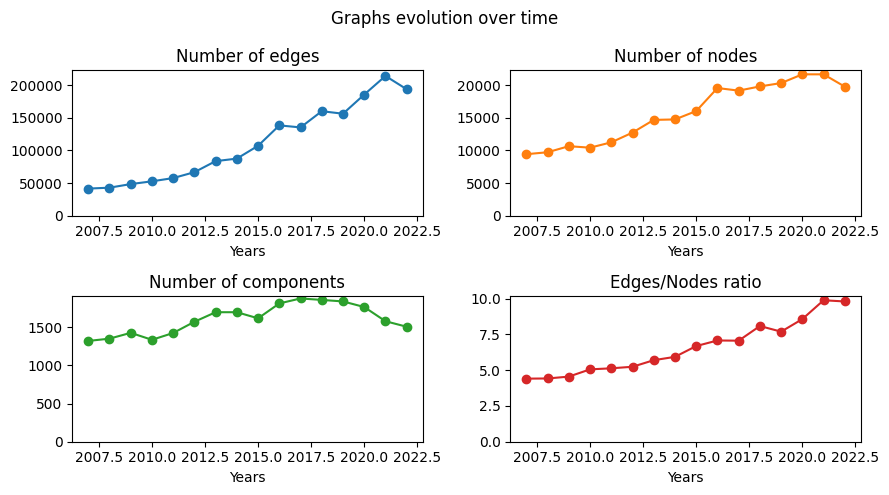

In [20]:
# plot the results in four different line charts
fig, axs = plt.subplots(2, 2, figsize=(9, 5))
axs[0, 0].plot(df_results['year'], df_results['no_edges'], marker='o', color='tab:blue')
axs[0, 0].set_title('Number of edges')
axs[0, 0].set_xlabel('Years')
axs[0, 0].set_ylim(bottom=0)

axs[0, 1].plot(df_results['year'], df_results['no_nodes'], marker='o', color='tab:orange')
axs[0, 1].set_title('Number of nodes')
axs[0, 1].set_xlabel('Years')
axs[0, 1].set_ylim(bottom=0)


axs[1, 0].plot(df_results['year'], df_results['no_components'], marker='o', color='tab:green')
axs[1, 0].set_title('Number of components')
axs[1, 0].set_xlabel('Years')
axs[1, 0].set_ylim(bottom=0)

axs[1, 1].plot(df_results['year'], df_results['edges_nodes_ratios'], marker='o', color='tab:red')
axs[1, 1].set_title('Edges/Nodes ratio')
axs[1, 1].set_xlabel('Years')
axs[1, 1].set_ylim(bottom=0)

# super title
fig.suptitle('Graphs evolution over time')
plt.tight_layout()
# show the plot
plt.show()


In [26]:
# create a dataframe for statistics per year

df_stats = pd.DataFrame({'no_authors': df.groupby('year')['researcher_id'].nunique(),
                         'no_publications': df.groupby('year')['pub_id'].nunique(),
                         'perc_LMIC': df.groupby('year')['LMIC'].mean(),
                         'perc_female': df.groupby('year')['gender'].mean(),
                         'no_publications_per_author': df.groupby('year')['pub_id'].nunique()/df.groupby('year')['researcher_id'].nunique(),
                         'no_author_per_publication': df.groupby('year')['researcher_id'].nunique()/df.groupby('year')['pub_id'].nunique()
                        })
df_stats.head()

,no_authors,no_publications,perc_LMIC,perc_female,no_publications_per_author,no_author_per_publication
year,,,,,,
2007,9429,2085,0.072938,0.265616,0.221126,4.522302
2008,9726,2150,0.080647,0.259099,0.221057,4.523721
2009,10653,2358,0.067710,0.262326,0.221346,4.517812
2010,10426,2276,0.088520,0.290933,0.218300,4.580844
2011,11247,2468,0.074362,0.275200,0.219436,4.557131


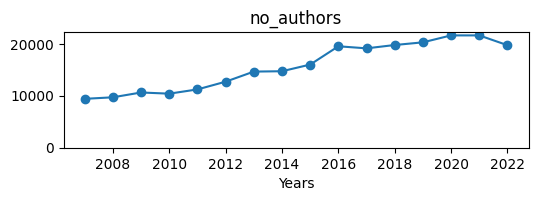

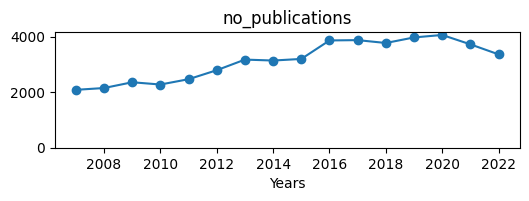

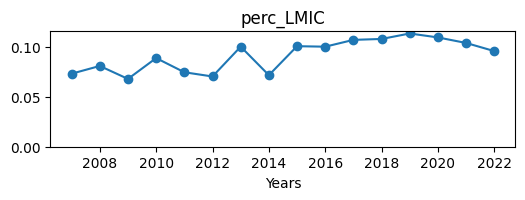

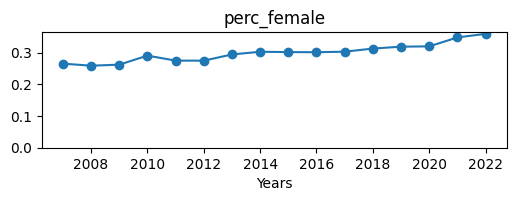

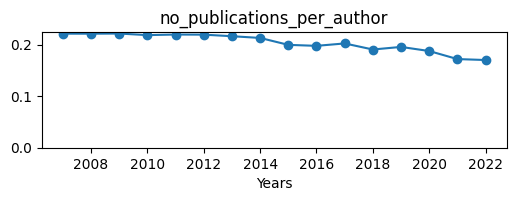

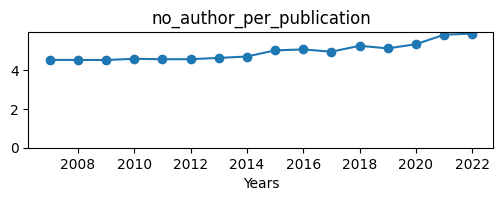

In [27]:
# create a loop to plot the statistics per year
for c in df_stats.columns:
    # smaller and more horizontal figure
    plt.figure(figsize=(6, 1.5))
    plt.plot(df_stats.index, df_stats[c], marker='o')
    plt.title(c)
    plt.xlabel('Years')
    plt.ylim(bottom=0)
    plt.show()

In [28]:
# merge the two dataframes, stats and results

df_results = df_results.merge(df_stats, left_on='year', right_on='year')

In [41]:
# only keep the columns we need for ploting
df_to_plot = df_results[['year',
                         'no_authors',
                         'no_publications',
                         'no_edges',
                         'edges_nodes_ratios',
                         'no_author_per_publication',
                         'no_publications_per_author',
                         'perc_LMIC',
                         'perc_female']].set_index('year')

In [42]:
df_to_plot.head()

,no_authors,no_publications,no_edges,edges_nodes_ratios,no_author_per_publication,no_publications_per_author,perc_LMIC,perc_female
year,,,,,,,,
2007,9429,2085,41581,4.409906,4.522302,0.221126,0.072938,0.265616
2008,9726,2150,43002,4.421345,4.523721,0.221057,0.080647,0.259099
2009,10653,2358,48495,4.552239,4.517812,0.221346,0.067710,0.262326
2010,10426,2276,52742,5.058699,4.580844,0.218300,0.088520,0.290933
2011,11247,2468,57718,5.131857,4.557131,0.219436,0.074362,0.275200


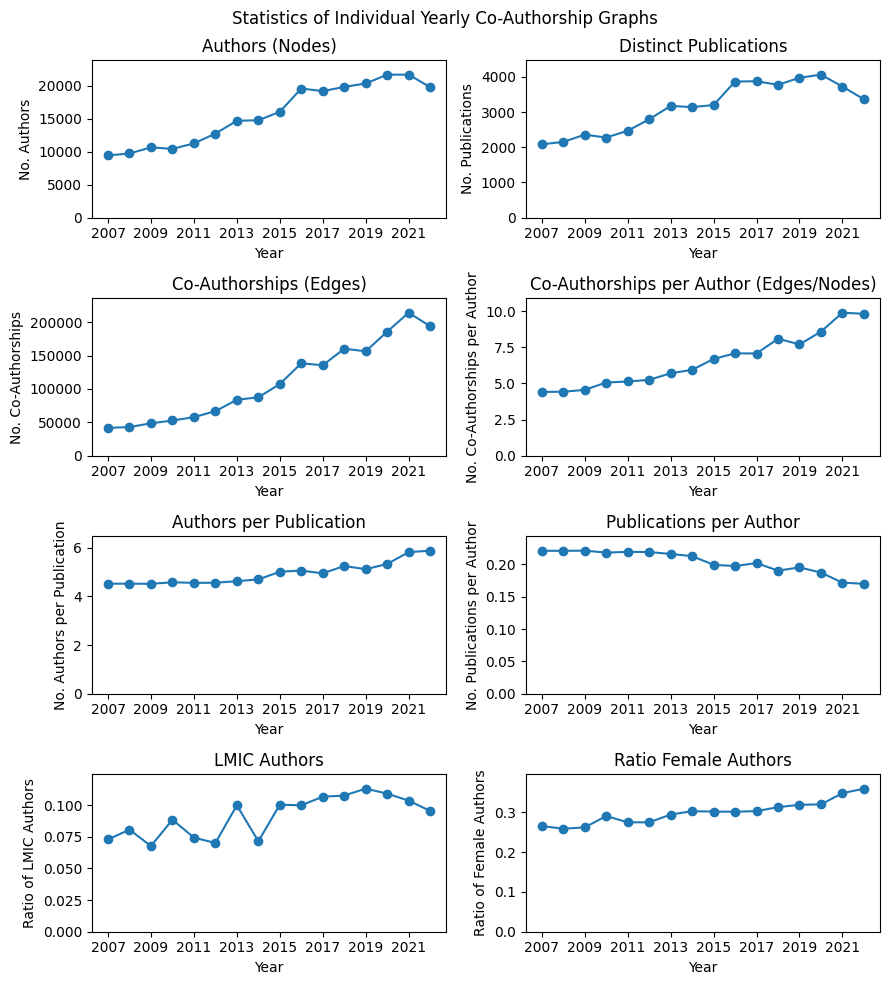

In [54]:
# create 4x2 subplot figure, 4 rows, 2 columns, A4 size
# create list with subtitles
xx_labels = ['No. Authors', 'No. Publications', 'No. Co-Authorships', 'No. Co-Authorships per Author',
             'No. Authors per Publication', 'No. Publications per Author', 'Ratio of LMIC Authors', 'Ratio of Female Authors']

subtitles = ['Authors (Nodes)', 'Distinct Publications', 'Co-Authorships (Edges)', 'Co-Authorships per Author (Edges/Nodes)',
             'Authors per Publication', 'Publications per Author', 'LMIC Authors', 'Ratio Female Authors']
             

fig, axs = plt.subplots(4, 2, figsize=(9, 10))

# loop through the columns
for i, c in enumerate(df_to_plot.columns):
    # plot the data
    axs[i//2, i%2].plot(df_to_plot.index, df_to_plot[c], marker='o')
    # set the title
    axs[i//2, i%2].set_title(subtitles[i])
    # set the x label
    axs[i//2, i%2].set_xlabel('Year')
    # set the y label
    axs[i//2, i%2].set_ylabel(xx_labels[i])
    # set the y limit
    axs[i//2, i%2].set_ylim(bottom=0, top=df_to_plot[c].max() + 0.1*df_to_plot[c].max())
    # set x ticks, but only for some years
    axs[i//2, i%2].set_xticks(df_to_plot.index[::2])

    
# super title
fig.suptitle('Statistics of Individual Yearly Co-Authorship Graphs')

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()

# save the plot
fig.savefig('results/year_graphs_summary.png', dpi=1000)